In [1]:
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
import astropy.units as u
from collections import Counter
import numpy as np
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
from astropy.io import fits
from radio_beam import Beam

In [2]:
# get the ACES beam.
# look for matches within the ACES's beam at ACES catalog locations.

In [3]:
aces_path = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_commonbeam_circular_reimaged_mosaic.fits'
hdr_aces = fits.getheader(aces_path)
beam_aces = Beam.from_fits_header(hdr_aces)  

In [4]:
B1_off = Table.read('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/dbcat/SgrB1off.dbcat_originalbeam_publish.txt', format='ascii')
Sgr_C = Table.read('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/dbcat/SgrC.dbcat_originalbeam_publish.txt', format='ascii')
kms20 = Table.read('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/dbcat/The20kmsCloud.dbcat_originalbeam_publish.txt', format='ascii')

In [5]:
B1_off_coords = SkyCoord(ra=B1_off['RA(hms)'], dec=B1_off['DEC(dms)'], unit=(u.hourangle, u.deg))
Sgr_C_coords = SkyCoord(ra=Sgr_C['RA(hms)'], dec=Sgr_C['DEC(dms)'], unit=(u.hourangle, u.deg))
kms20_coords = SkyCoord(ra=kms20['RA(hms)'], dec=kms20['DEC(dms)'], unit=(u.hourangle, u.deg))

In [6]:
three_clouds_cat = vstack([B1_off, Sgr_C, kms20])
three_clouds_coords = SkyCoord(ra=three_clouds_cat['RA(hms)'], dec=three_clouds_cat['DEC(dms)'], unit=(u.hourangle, u.deg))

In [7]:
ACES_cat_path = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/cmz_sfr/aces_catalog_mv3_ms0.5_mp7_rms0.0001_min_peak0.0004_bl20_localrms2_globalrms3_tgif_fs1.0_2024_12_17_fullmask.fits'
ACES_cat = Table.read(ACES_cat_path)
ACES_coords = SkyCoord(l = ACES_cat['GLON']*u.deg, b = ACES_cat['GLAT']*u.deg, frame='galactic')

In [8]:
radius = ((beam_aces.major+beam_aces.minor)/2)*1.5
# Looking for (highres) around (lowres) coords (aces)
idxc, idxcatalog, d2d, d3d = three_clouds_coords.search_around_sky(ACES_coords, radius)

In [9]:
len(three_clouds_coords)

450

In [10]:
occurances_lowres = np.array(Counter(idxc).most_common())[:,1]

In [11]:
Counter(idxc).values()

dict_values([4, 5, 2, 1, 4, 1, 2, 15, 15, 14, 4, 11, 4, 17, 1, 23, 17, 4, 18, 12, 14, 1, 12, 14, 5, 8, 5, 21, 2, 8, 2, 8, 13, 1, 2, 15, 1, 3, 1, 5, 1, 5, 19, 13, 1, 2, 1, 17, 6, 7, 16, 14, 3, 1])

In [12]:
ids_ACES = np.array(Counter(idxc).most_common())[:,0]

In [13]:
occurances_lowres_over1 = occurances_lowres[occurances_lowres>1]
ids_ACES_over1 = ids_ACES[occurances_lowres>1]

occurances_lowres_1 = occurances_lowres[occurances_lowres==1]
ids_ACES_1 = ids_ACES[occurances_lowres==1]

In [14]:
import matplotlib.pyplot as plt

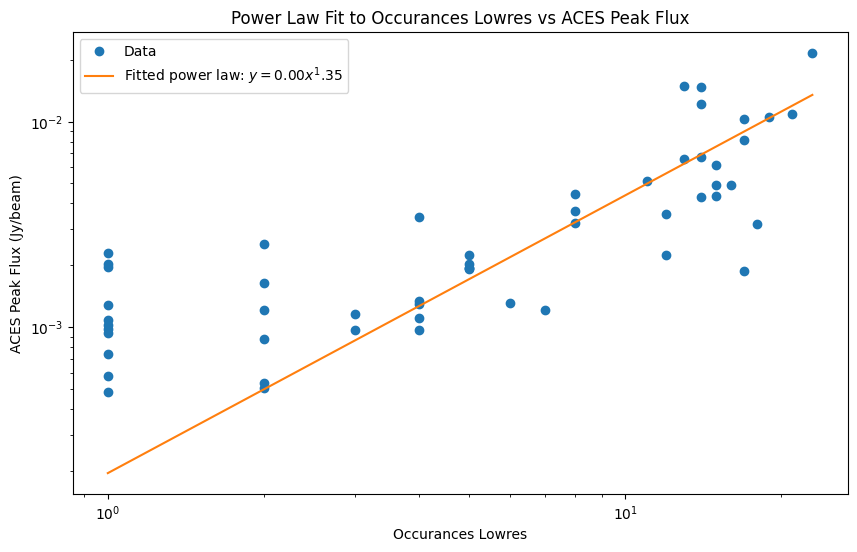

In [15]:
from scipy.optimize import curve_fit

# Define the power law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power law to the data
popt, pcov = curve_fit(power_law, occurances_lowres, ACES_cat[ids_ACES]['peak_flux'])

# Extract the parameters
a, b = popt

# Generate the fitted line
fit_line_power_law = power_law(occurances_lowres, a, b)

# Plot the original data and the fitted power law
plt.figure(figsize=(10, 6))
plt.plot(occurances_lowres, ACES_cat[ids_ACES]['peak_flux'], 'o', label='Data')
plt.plot(occurances_lowres, fit_line_power_law, '-', label=f'Fitted power law: $y = {a:.2f}x^{b:.2f}$')
plt.xlabel('Occurances Lowres')
plt.ylabel('ACES Peak Flux (Jy/beam)')
plt.legend()
plt.title('Power Law Fit to Occurances Lowres vs ACES Peak Flux')
plt.yscale('log')
plt.xscale('log')
plt.show()

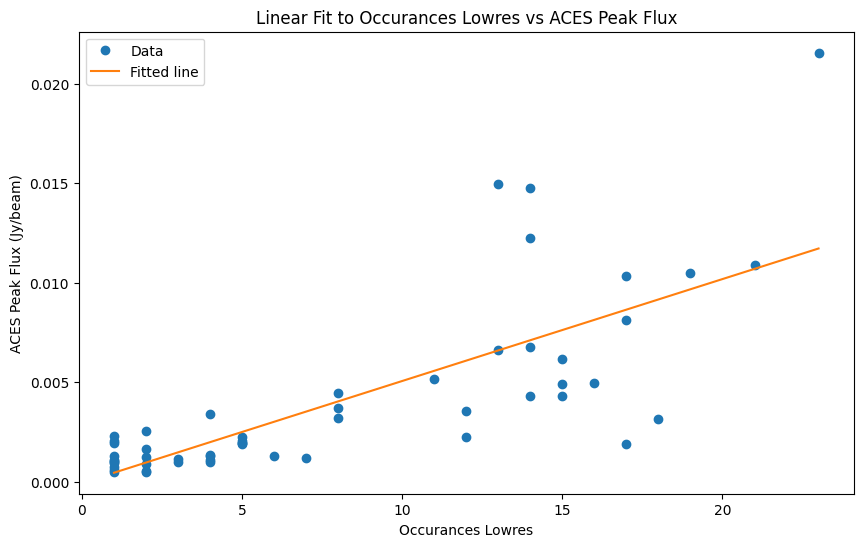

In [16]:
# Fit a line to (occurances_lowres, ACES_cat[ids_ACES]['peak_flux'])
coefficients = np.polyfit(occurances_lowres, ACES_cat[ids_ACES]['peak_flux'], 1)
fit_line = np.polyval(coefficients, occurances_lowres)

# Plot the original data and the fitted line
plt.figure(figsize=(10, 6))
plt.plot(occurances_lowres, ACES_cat[ids_ACES]['peak_flux'], 'o', label='Data')
plt.plot(occurances_lowres, fit_line, '-', label='Fitted line')
plt.xlabel('Occurances Lowres')
plt.ylabel('ACES Peak Flux (Jy/beam)')
plt.legend()
plt.title('Linear Fit to Occurances Lowres vs ACES Peak Flux')
plt.show()

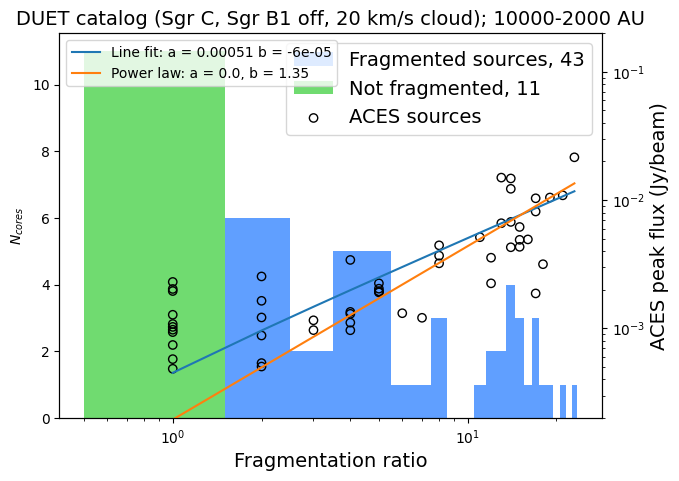

In [17]:
fontsize = 14
fig, ax = plt.subplots(figsize=(7,5))

bins=np.linspace(-0.5,np.max(occurances_lowres_over1)+0.5, np.max(occurances_lowres_over1)+2)
#bins = np.logspace(0,np.max(occurances_lowres_over1)+0.5, np.max(occurances_lowres_over1)+2)
plt.hist(occurances_lowres_over1, alpha = 1, linewidth = 2, histtype = 'stepfilled', ec = 'blue', bins=bins, 
         label = 'Fragmented sources, '+str(len(occurances_lowres_over1)), color = '#609fff')
plt.hist(occurances_lowres_1, alpha = 0.7, linewidth = 2, histtype = 'stepfilled', bins=np.linspace(0.5,1.5, 2), 
         label = 'Not fragmented, '+str(len(occurances_lowres_1)), color = '#33cc33', ec = 'green')
#plt.hist([number_of_lowres_resolved_out, number_of_lowres_resolved_out_low_conf], alpha = 0.7, linewidth = 2, 
#         histtype = 'stepfilled', color = ['red', 'orange'], 
#         label = ['Resolved out, '+str(len(number_of_lowres_resolved_out)), 'Resolved out, low confidence, '+str(len(number_of_lowres_resolved_out_low_conf))])
#         ec = 'orange', bins=np.linspace(-0.5,0.5, 2), stacked = True, hatch=['/','|'],  

plt.xlabel('Fragmentation ratio', fontsize = fontsize)
plt.ylabel(r'$N_{cores}$')

plt.scatter(np.nan,np.nan, marker = 'o', color = 'k', facecolors='none', edgecolors='k', label = 'ACES sources') 
plt.legend(fontsize = fontsize,)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.scatter(occurances_lowres, ACES_cat[ids_ACES]['peak_flux'], marker = 'o', color = 'k', facecolors='none', edgecolors='k')
ax2.plot(occurances_lowres, fit_line, '-', label=f'Line fit: a = {round(coefficients[0],5)} b = {round(coefficients[1],5)}')

#ax2.scatter(number_of_lowres_resolved_out, arr_resolved_out, marker = 'o', color = 'k', facecolors='none', edgecolors='k')
#ax2.scatter(number_of_lowres_resolved_out_low_conf, arr_resolved_out_low_conf, marker = 'o', color = 'k', facecolors='none', edgecolors='k')
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.0002,0.2)
ax2.plot(occurances_lowres, fit_line_power_law, '-', label=f'Power law: a = {round(a,2)}, b = {round(b,2)}')
ax2.set_ylabel("ACES peak flux (Jy/beam)",fontsize=14)
plt.title('DUET catalog (Sgr C, Sgr B1 off, 20 km/s cloud); 10000-2000 AU', fontsize = fontsize)

ax2.legend(loc = 'upper left')  
#plt.savefig('flux_fragmentation.png',dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'DUET catalog (Sgr C, Sgr B1 off, 20 km/s cloud); 10000-2000 AU')

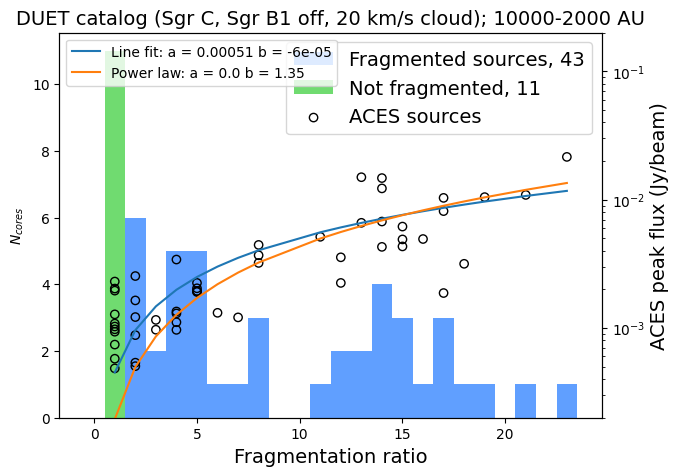

In [18]:
fontsize = 14
fig, ax = plt.subplots(figsize=(7,5))

bins=np.linspace(-0.5,np.max(occurances_lowres_over1)+0.5, np.max(occurances_lowres_over1)+2)
#bins = np.logspace(0,np.max(occurances_lowres_over1)+0.5, np.max(occurances_lowres_over1)+2)
plt.hist(occurances_lowres_over1, alpha = 1, linewidth = 2, histtype = 'stepfilled', ec = 'blue', bins=bins, 
         label = 'Fragmented sources, '+str(len(occurances_lowres_over1)), color = '#609fff')
plt.hist(occurances_lowres_1, alpha = 0.7, linewidth = 2, histtype = 'stepfilled', bins=np.linspace(0.5,1.5, 2), 
         label = 'Not fragmented, '+str(len(occurances_lowres_1)), color = '#33cc33', ec = 'green')
#plt.hist([number_of_lowres_resolved_out, number_of_lowres_resolved_out_low_conf], alpha = 0.7, linewidth = 2, 
#         histtype = 'stepfilled', color = ['red', 'orange'], 
#         label = ['Resolved out, '+str(len(number_of_lowres_resolved_out)), 'Resolved out, low confidence, '+str(len(number_of_lowres_resolved_out_low_conf))])
#         ec = 'orange', bins=np.linspace(-0.5,0.5, 2), stacked = True, hatch=['/','|'],  

plt.xlabel('Fragmentation ratio', fontsize = fontsize)
plt.ylabel(r'$N_{cores}$')

plt.scatter(np.nan,np.nan, marker = 'o', color = 'k', facecolors='none', edgecolors='k', label = 'ACES sources') 
 
plt.legend(fontsize = fontsize,)  
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.scatter(occurances_lowres, ACES_cat[ids_ACES]['peak_flux'], marker = 'o', color = 'k', facecolors='none', edgecolors='k')
ax2.plot(occurances_lowres, fit_line, '-', label=f'Line fit: a = {round(coefficients[0],5)} b = {round(coefficients[1],5)}')

#ax2.scatter(number_of_lowres_resolved_out, arr_resolved_out, marker = 'o', color = 'k', facecolors='none', edgecolors='k')
#ax2.scatter(number_of_lowres_resolved_out_low_conf, arr_resolved_out_low_conf, marker = 'o', color = 'k', facecolors='none', edgecolors='k')
plt.yscale('log')
#plt.xscale('log')
plt.ylim(0.0002,0.2)
ax2.plot(occurances_lowres, fit_line_power_law, '-', label=f'Power law: a = {round(a,2)} b = {round(b,2)}')
ax2.set_ylabel("ACES peak flux (Jy/beam)",fontsize=14)
ax2.legend(loc = 'upper left')
plt.title('DUET catalog (Sgr C, Sgr B1 off, 20 km/s cloud); 10000-2000 AU', fontsize = fontsize)

#plt.savefig('flux_fragmentation.png',dpi=300,bbox_inches='tight')

### Comparing fragmentation to spectral index from ACES 

In [19]:
path_to_mosaic = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_commonbeam_circular_reimaged_mosaic.fits'
#path_to_mosaic = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_reimaged_mosaic.fits'
#path_to_mosaic = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_mosaic.fits'
#path_to_mosaic = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_reimaged_mosaic-1.fits' #most recent
#path_to_mosaic = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_commonbeam_circular_mosaic.fits'
mosaic_hdul = fits.open(path_to_mosaic)
data = mosaic_hdul[0].data
wcs_aces = WCS(mosaic_hdul[0].header)

In [20]:
ACES_cat[0]

index,area_ellipse,area_exact,flux_integrated,major_sigma,minor_sigma,position_angle,radius,GLON,GLAT,is_leaf,peak_cont_flux,min_cont_flux,mean_cont_flux,bgsub_flux_integrated,npix,noise,x_peak,y_peak,axis_ratio,mass,bgsub_mass,eff_radius,eff_radius_pc,fit_size,flux,flux_err,pa,pa_err,fitted_major,fitted_major_err,fitted_minor,fitted_minor_err,deconvolved_major,deconvolved_minor,peak_flux
,arcsec2,arcsec2,Jy,arcsec,arcsec,deg,arcsec,,,,,,,,,,,,arcsec,solMass,solMass,arcsec,pc,,Jy,Jy,deg,deg,deg,deg,deg,deg,deg,deg,Jy / beam
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
29,1.4134235256472019,4.249999999456,0.00033227785974741694,0.7377516067246516,0.4399103864695902,-158.10424191582493,0.5696881554261091,0.8259237000760948,-0.28058442407622186,True,0.0006940888598382407,0.0005016605964587352,0.0005805955716392202,4.5175293352059536e-05,17,0.0002805859993649477,600,226,1.6770497569864729,12.193566526659092,1.657793105048915,1.1631066228458808,0.046114881155957695,0.9086633713720784,0.0010619540645671677,1.2614510057519261e-06,29.77333011728697,3.636468145771856,0.000870155577132896,2.3838552368756442e-05,0.0006815617042360299,1.425314857739187e-05,0.0,0.0,0.0006276493852050102


In [21]:
o = 100
x = ACES_cat[o]['x_peak']
y = ACES_cat[o]['y_peak']
peak_cat = ACES_cat[o]['peak_cont_flux']
peak_data = data[y][x]
print(peak_cat, peak_data)

0.00041617079265504695 0.00041617079265504695


In [22]:
path_to_alpha = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_commonbeam_circular_reimaged_alpha_mosaic.fits'
#path_to_alpha = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_commonbeam_circular_reimaged_manual_alpha_mosaic.fits' # this is a backup option
path_to_alpha_err = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_commonbeam_circular_reimaged_alphaerror_mosaic.fits'
mosaic_hdul_alpha = fits.open(path_to_alpha)
data_alpha = mosaic_hdul_alpha[0].data
mosaic_hdul_alpha_err = fits.open(path_to_alpha_err)
data_alpha_err = mosaic_hdul_alpha_err[0].data

alphas = []
alphas_err = []
for i in range(len(ACES_cat)):
    alpha = data_alpha[ACES_cat[i]['y_peak']][ACES_cat[i]['x_peak']]
    alpha_err = data_alpha_err[ACES_cat[i]['y_peak']][ACES_cat[i]['x_peak']]
    alphas.append(alpha)
    alphas_err.append(alpha_err)

In [23]:
alphas_filtered = alphas
for i in range(len(alphas_filtered)):
    if alphas_filtered[i] < 0:
        alphas_filtered[i] = np.nan
    if alphas_filtered[i] > 1:
        alphas_filtered[i] = np.nan

In [24]:
alphas_filtered_err = alphas_err
for i in range(len(alphas_filtered_err)):
    if alphas_filtered_err[i] < 0:
        alphas_filtered_err[i] = np.nan
    if alphas_filtered_err[i] > 1:
        alphas_filtered_err[i] = np.nan

Text(0.5, 1.0, 'SI_err < 1')

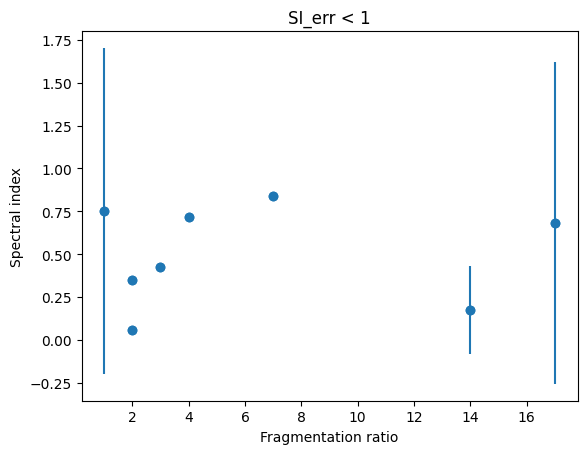

In [25]:
# This plot is wrong, the x in scatter is in messed up order
# nevermind.. it was right. The order of both arrays was sorter
plt.scatter(occurances_lowres, np.array(alphas_filtered)[ids_ACES])
plt.errorbar(occurances_lowres, np.array(alphas_filtered)[ids_ACES], yerr = np.array(alphas_filtered_err)[ids_ACES], fmt = 'o')
plt.xlabel('Fragmentation ratio')
plt.ylabel('Spectral index')
plt.title('SI_err < 1')

In [26]:
meerkat_hdul = fits.open('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/MeerKAT_Galactic_Centre_1284MHz-StokesI.fits')
meerkat = meerkat_hdul[0].data
wcs_meerkat = WCS(meerkat_hdul[0].header)

aces_reproj_hdul = fits.open('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/cmz_sfr/12m_continuum_commonbeam_circular_reimaged_mosaic_convolved_with_meerkat.fits')
aces_reproj = aces_reproj_hdul[0].data
wcs_aces_reproj = WCS(aces_reproj_hdul[0].header)

In [27]:
def get_spectral_index(data1, data2, freq1, freq2):
    # ACES_RMS = 2.5e-4
    # MEERKAT_RMS = 2e-4
    # if ACES_RMS*5 > data1:
    #     data1 = np.nan
    # if MEERKAT_RMS*5 > data2:
    #     data2 = np.nan
    return np.log(data1/data2)/np.log(freq1/freq2)

In [28]:
# positive -- ACES is higher
# negative -- MEERKAT is higher
# if ACES is noise, the SI will be an overestimation (upper limit)
# if MEERKAT is noise, the SI will be an underestimation (lower limit)

In [29]:
# introducing zooniversed catalog:
ACES_cat_path = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/cmz_sfr/aces_catalog_mv3_ms0.5_mp7_rms0.0001_min_peak0.0004_bl20_localrms2_globalrms3_tgif_fs1.0_2024_12_17_fullmask.fits'
#ACES_cat_path = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/cmz_sfr/aces_catalog_mv3_ms0.5_mp7_rms0.0001_min_peak0.0004_bl20_localrms2_globalrms3_tgif_fs1.0_2024_12_17_fullmask_0.6thresh_40perc.fits'
ACES_cat = Table.read(ACES_cat_path)

In [30]:
aces_freq = 100 * u.GHz
meerkat_freq = 1.284 * u.GHz
alphas_meerkat_aces = []
ACES_5rms_mask = np.zeros(len(ACES_cat), dtype=bool)
MEERKAT_5rms_mask = np.zeros(len(ACES_cat), dtype=bool)
ACES_RMS = 2.5e-4
MEERKAT_RMS = 2e-4
for i in range(len(ACES_cat)):
    x = ACES_cat[i]['x_peak']
    y = ACES_cat[i]['y_peak']
    ACES_coord = SkyCoord(l = ACES_cat[i]['GLON']*u.deg, b = ACES_cat[i]['GLAT']*u.deg, frame='galactic')
    x_meerkat, y_meerkat = ACES_coord.to_pixel(wcs_meerkat)
    x_meerkat = int(np.round(x_meerkat))
    y_meerkat = int(np.round(y_meerkat))

    alpha = get_spectral_index(aces_reproj[y][x], meerkat[y_meerkat][x_meerkat], aces_freq, meerkat_freq)
    alphas_meerkat_aces.append(alpha)

    if aces_reproj[y][x] < ACES_RMS*5:
        ACES_5rms_mask[i] = True
    if meerkat[y_meerkat][x_meerkat] < MEERKAT_RMS*5:
        MEERKAT_5rms_mask[i] = True

/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: in

In [31]:
alphas_meerkat_aces = np.array(alphas_meerkat_aces)

In [32]:
aces_hdul = fits.open('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_commonbeam_circular_reimaged_mosaic.fits')
aces = aces_hdul[0].data
wcs_aces = WCS(aces_hdul[0].header)
aces_beam = Beam.from_fits_header(aces_hdul[0].header)
cmzoom_hdul = fits.open('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/CMZoom_continuum_pbcor.fits')
cmzoom = cmzoom_hdul[0].data
wcs_cmzoom = WCS(cmzoom_hdul[0].header)

aces_jy_per_sr = aces / aces_beam.sr

In [33]:
cmzoom.shape

(2800, 19000)

<Quantity 0.85475565>

In [34]:
aces_freq = 100 * u.GHz
cmzoom_freq = 225 * u.GHz
alphas_cmzoom_aces = []
ACES_5rms_mask_CMZOOM = np.zeros(len(ACES_cat), dtype=bool)
CMZOOM_5rms_mask = np.zeros(len(ACES_cat), dtype=bool)
ACES_RMS = (2.5e-4 /(aces_beam.sr)).value
CMZOOM_RMS = 2 * 10**7
for i in range(len(ACES_cat)):
    x = ACES_cat[i]['x_peak']
    y = ACES_cat[i]['y_peak']
    ACES_coord = SkyCoord(l = ACES_cat[i]['GLON']*u.deg, b = ACES_cat[i]['GLAT']*u.deg, frame='galactic')
    x_cmzoom, y_cmzoom = ACES_coord.to_pixel(wcs_cmzoom)
    x_cmzoom = int(np.round(x_cmzoom))
    y_cmzoom = int(np.round(y_cmzoom))

    pixel_value_aces = aces_jy_per_sr[y][x].value
    try:
        pixel_value_cmzoom = cmzoom[y_cmzoom][x_cmzoom]
    except IndexError:
        pixel_value_cmzoom = np.nan

    #alpha = get_spectral_index(aces_jy_per_sr[y][x].value, cmzoom[y_cmzoom][x_cmzoom], aces_freq, cmzoom_freq)
    alpha = get_spectral_index(pixel_value_aces, pixel_value_cmzoom, aces_freq, cmzoom_freq)
    alphas_cmzoom_aces.append(alpha.value)

    if pixel_value_aces < ACES_RMS*5:
        ACES_5rms_mask_CMZOOM[i] = True
    if pixel_value_cmzoom < CMZOOM_RMS*5:
        CMZOOM_5rms_mask[i] = True

alphas_cmzoom_aces = np.array(alphas_cmzoom_aces)

/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(data1/data2)/np.log(freq1/freq2)
/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/1181297923.py:8: RuntimeWarning: in

Text(0, 0.5, 'Number of sources')

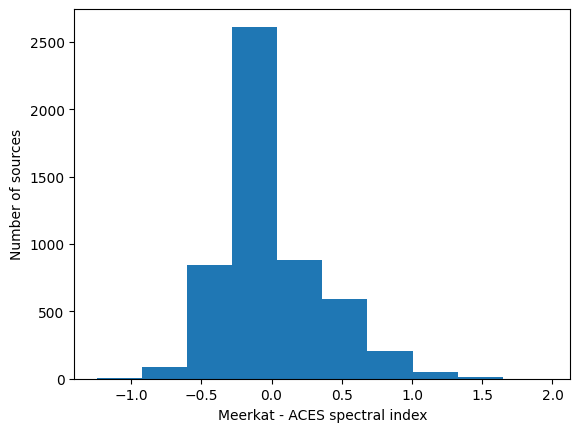

In [35]:
plt.hist(alphas_meerkat_aces)
plt.xlabel('Meerkat - ACES spectral index')
plt.ylabel('Number of sources')

Text(0, 0.5, 'Number of sources')

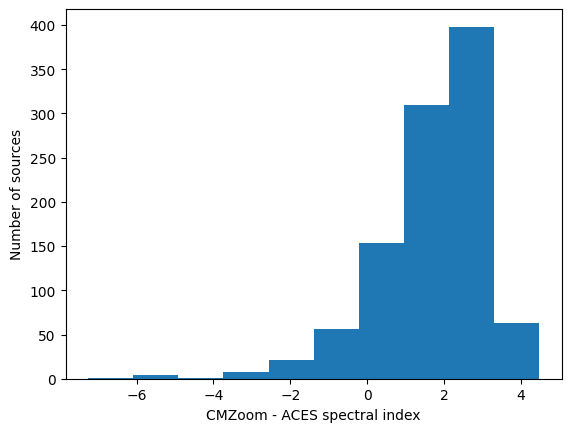

In [36]:
plt.hist(alphas_cmzoom_aces)
plt.xlabel('CMZoom - ACES spectral index')
plt.ylabel('Number of sources')

In [37]:
# keys_array = np.array(list(Counter(idxc).keys()))
# #keys_array
# values_array = np.array(list(Counter(idxc).values()))
# #values_array

In [97]:
# this is important for the FRAGMENTATION
only_ACES_below_5RMS_ = MEERKAT_5rms_mask[ids_ACES] & ~ACES_5rms_mask[ids_ACES]
only_MEERKAT_below_5RMS_ = ACES_5rms_mask[ids_ACES] & ~MEERKAT_5rms_mask[ids_ACES]
both_below_5RMS_ = ACES_5rms_mask[ids_ACES] | MEERKAT_5rms_mask[ids_ACES]

#only_ACES_below_5RMS_cmzoom = CMZOOM_5rms_mask[ids_ACES] & ~ACES_5rms_mask_CMZOOM[ids_ACES]
only_ACES_below_5RMS_cmzoom = CMZOOM_5rms_mask[ids_ACES] & ~ACES_5rms_mask_CMZOOM[ids_ACES]
only_CMZOOM_below_5RMS = ACES_5rms_mask_CMZOOM[ids_ACES] & ~CMZOOM_5rms_mask[ids_ACES]
both_below_5RMS_cmzoom = ACES_5rms_mask_CMZOOM[ids_ACES] | CMZOOM_5rms_mask[ids_ACES]

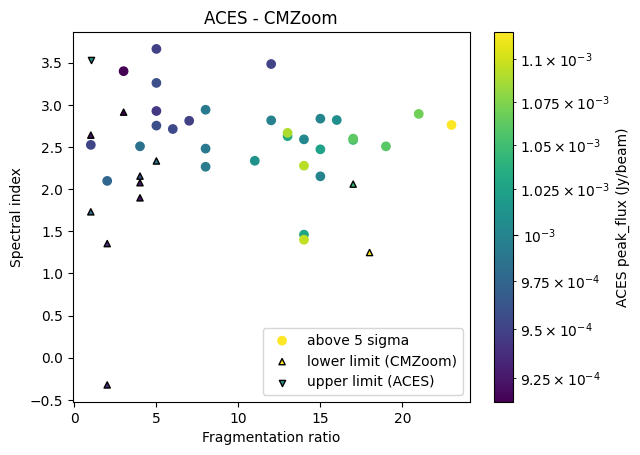

In [100]:
plt.scatter(occurances_lowres[~both_below_5RMS_cmzoom], np.array(alphas_cmzoom_aces)[ids_ACES][~both_below_5RMS_cmzoom], c = ACES_cat['peak_cont_flux'][ids_ACES][~both_below_5RMS_cmzoom], cmap = 'viridis', norm = LogNorm(), label = 'above 5 sigma')
plt.scatter(occurances_lowres[only_ACES_below_5RMS_cmzoom], np.array(alphas_cmzoom_aces)[ids_ACES][only_ACES_below_5RMS_cmzoom], c = ACES_cat['peak_cont_flux'][ids_ACES][only_ACES_below_5RMS_cmzoom], cmap = 'viridis', norm = LogNorm(), label = 'lower limit (CMZoom)', marker = '^', s = 20, ec = 'k')
plt.scatter(occurances_lowres[only_CMZOOM_below_5RMS], np.array(alphas_cmzoom_aces)[ids_ACES][only_CMZOOM_below_5RMS], c = ACES_cat['peak_cont_flux'][ids_ACES][only_CMZOOM_below_5RMS], cmap = 'viridis', norm = LogNorm(), label = 'upper limit (ACES)', marker = 'v', s = 20, ec ='k')
plt.colorbar(label ='ACES peak_flux (Jy/beam)')
plt.xlabel('Fragmentation ratio')
plt.ylabel('Spectral index')
plt.title('ACES - CMZoom')
plt.legend()

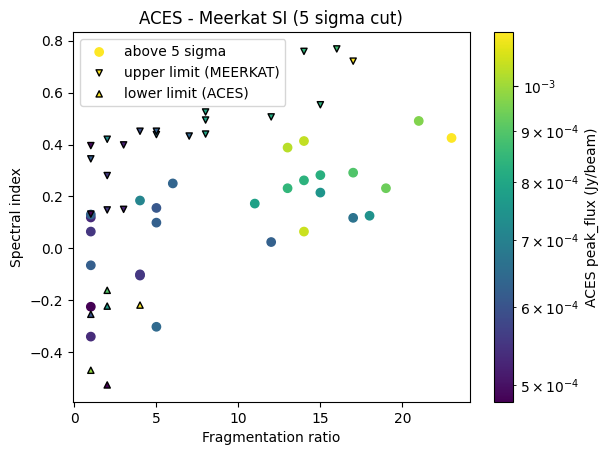

In [39]:
plt.scatter(occurances_lowres[~both_below_5RMS_], np.array(alphas_meerkat_aces)[ids_ACES][~both_below_5RMS_], c = ACES_cat['peak_cont_flux'][ids_ACES][~both_below_5RMS_], cmap = 'viridis', norm = LogNorm(), label = 'above 5 sigma')
plt.scatter(occurances_lowres[only_ACES_below_5RMS_], np.array(alphas_meerkat_aces)[ids_ACES][only_ACES_below_5RMS_], c = ACES_cat['peak_cont_flux'][ids_ACES][only_ACES_below_5RMS_], cmap = 'viridis', norm = LogNorm(), label = 'upper limit (MEERKAT)', marker = 'v', s = 20, ec = 'k')
plt.scatter(occurances_lowres[only_MEERKAT_below_5RMS_], np.array(alphas_meerkat_aces)[ids_ACES][only_MEERKAT_below_5RMS_], c = ACES_cat['peak_cont_flux'][ids_ACES][only_MEERKAT_below_5RMS_], cmap = 'viridis', norm = LogNorm(), label = 'lower limit (ACES)', marker = '^', s = 20, ec ='k')
plt.colorbar(label ='ACES peak_flux (Jy/beam)')
plt.xlabel('Fragmentation ratio')
plt.ylabel('Spectral index')
plt.title('ACES - Meerkat SI (5 sigma cut)')
plt.legend()

Text(0.5, 1.0, '5 sigma cut on both ACES and Meerkat')

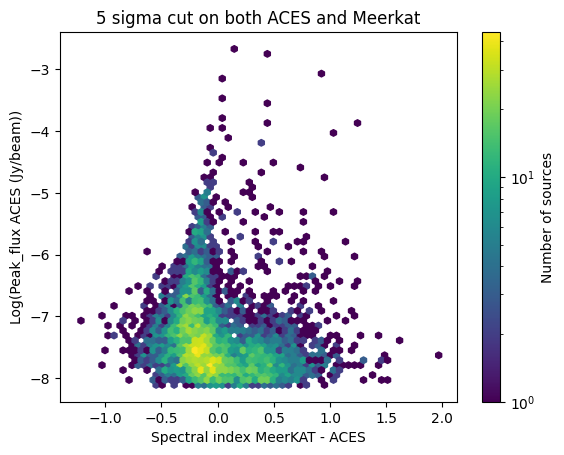

In [40]:
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
gridsize = 60
x = alphas_meerkat_aces
y = np.log(ACES_cat['peak_flux'])
hb = plt.hexbin(x, y, gridsize=gridsize, cmap='viridis', norm=LogNorm())
#plt.yscale('log')
plt.xlabel('Spectral index MeerKAT - ACES')
plt.ylabel('Log(Peak_flux ACES (Jy/beam))')
plt.colorbar(label='Number of sources')
plt.title('5 sigma cut on both ACES and Meerkat')

In [41]:
# SI_upper_limits = np.array(alphas_meerkat_aces)[ACES_5rms_mask]
# SI_lower_limits = np.array(alphas_meerkat_aces)[MEERKAT_5rms_mask]
# ACES_MEERKAT_5rms_mask = np.logical_or(ACES_5rms_mask, MEERKAT_5rms_mask)
# SI_above_5RMS = np.array(alphas_meerkat_aces)[~ACES_MEERKAT_5rms_mask]

only_ACES_below_5RMS = ACES_5rms_mask & ~MEERKAT_5rms_mask  # ACES < 5σ, MEERKAT >= 5σ
only_MEERKAT_below_5RMS = MEERKAT_5rms_mask & ~ACES_5rms_mask  # MEERKAT < 5σ, ACES >= 5σ
ACES_MEERKAT_5rms_mask = ACES_5rms_mask | MEERKAT_5rms_mask  # Either one is below 5σ

# Apply masks
SI_upper_limits = alphas_meerkat_aces[only_ACES_below_5RMS]  # Only ACES < 5σ
SI_lower_limits = alphas_meerkat_aces[only_MEERKAT_below_5RMS]  # Only MEERKAT < 5σ
SI_above_5RMS = alphas_meerkat_aces[~ACES_MEERKAT_5rms_mask]  # Neither below 5σ



only_ACES_below_5RMS_cmzoom = ACES_5rms_mask_CMZOOM & ~CMZOOM_5rms_mask
only_CMZOOM_below_5RMS =  CMZOOM_5rms_mask & ~ACES_5rms_mask_CMZOOM
both_below_5RMS_cmzoom = ACES_5rms_mask_CMZOOM | CMZOOM_5rms_mask

# Apply masks
SI_lower_limits_cmzoom = alphas_cmzoom_aces[only_ACES_below_5RMS_cmzoom]  # 
SI_upper_limits_cmzoom = alphas_cmzoom_aces[only_CMZOOM_below_5RMS]  # 
SI_above_5RMS_cmzoom = alphas_cmzoom_aces[~both_below_5RMS_cmzoom]  # 


In [42]:
np.sum(~np.isnan(SI_upper_limits_cmzoom))

np.int64(166)

In [43]:
np.sum(~np.isnan(SI_lower_limits_cmzoom))

np.int64(3)

In [44]:
np.sum(~np.isnan(alphas_cmzoom_aces)) - np.sum(~np.isnan(SI_lower_limits_cmzoom)) - np.sum(~np.isnan(SI_upper_limits_cmzoom))

np.int64(846)

In [ ]:
ACES_cat.add_column(alphas_meerkat_aces, name='SI_Meerkat_ACES')
ACES_cat.add_column(alphas_cmzoom_aces, name='SI_CMZoom_ACES')
ACES_cat.add_column(only_ACES_below_5RMS, name='upper limit meerkat')
ACES_cat.add_column(only_MEERKAT_below_5RMS, name='lower limit meerkat')
ACES_cat.add_column(only_CMZOOM_below_5RMS, name='upper limit cmzoom')
ACES_cat.add_column(only_ACES_below_5RMS_cmzoom, name='lower limit cmzoom')

In [46]:
#mask_ = (~ACES_cat['upper limit meerkat']) & (~ACES_cat['lower limit meerkat']) & (~ACES_cat["upper limit cmzoom"]) & (~ACES_cat['lower limit cmzoom'])
mask_ = (~both_below_5RMS_cmzoom) & (~ACES_MEERKAT_5rms_mask)

In [47]:
np.sum(mask_)

np.int64(670)

In [48]:
np.sum(~np.isnan(SI_above_5RMS))

np.int64(1854)

In [49]:
np.sum(~np.isnan(SI_above_5RMS_cmzoom))

np.int64(65)

Text(0.5, 1.0, 'Above 5 sigma in all three data')

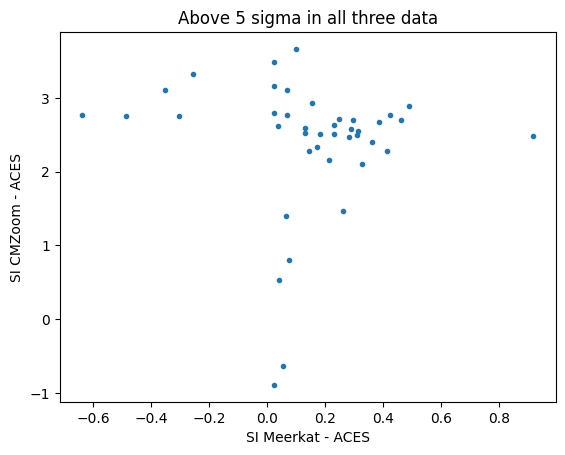

In [50]:
plt.scatter(ACES_cat['SI_Meerkat_ACES'][mask_], ACES_cat['SI_CMZoom_ACES'][mask_], marker = '.')
plt.xlabel('SI Meerkat - ACES')
plt.ylabel('SI CMZoom - ACES')
plt.title('Above 5 sigma in all three data')

Text(0.5, 1.0, '5 sigma cut on both ACES and Meerkat')

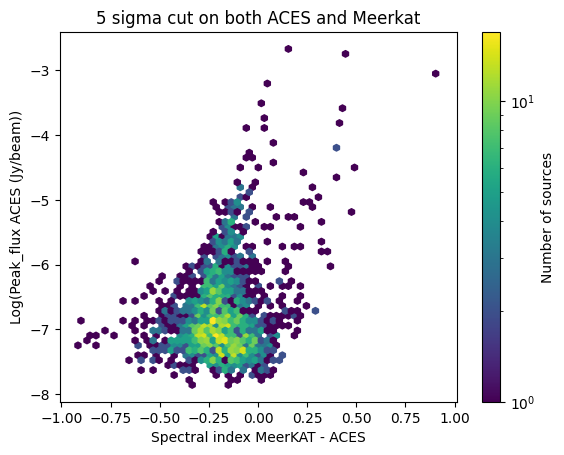

In [51]:
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
gridsize = 60
x = SI_above_5RMS
y = np.log(ACES_cat['peak_flux'][~ACES_MEERKAT_5rms_mask])
hb = plt.hexbin(x, y, gridsize=gridsize, cmap='viridis', norm=LogNorm())
#plt.yscale('log')
plt.xlabel('Spectral index MeerKAT - ACES')
plt.ylabel('Log(Peak_flux ACES (Jy/beam))')
plt.colorbar(label='Number of sources')
plt.title('5 sigma cut on both ACES and Meerkat')

(0.0002, 0.2)

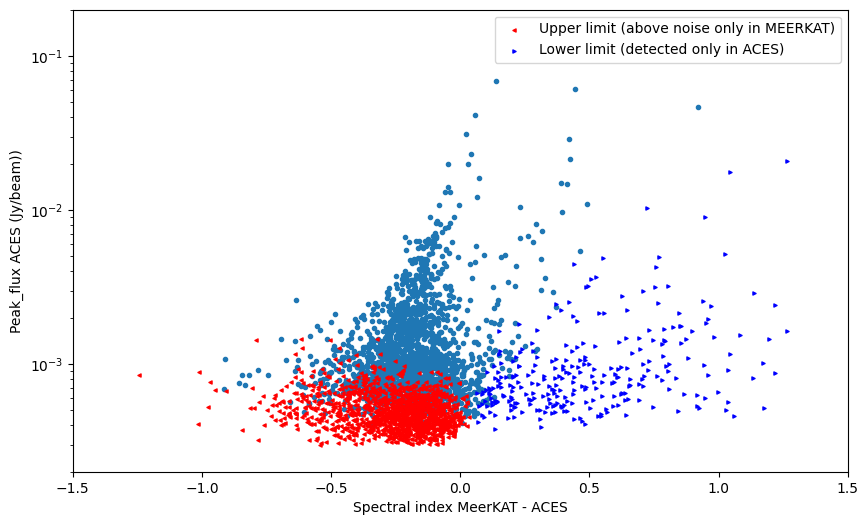

In [52]:
plt.figure(figsize=(10, 6))
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
plt.scatter(SI_above_5RMS, ACES_cat['peak_flux'][~ACES_MEERKAT_5rms_mask], marker = '.')
plt.scatter(SI_upper_limits, ACES_cat['peak_flux'][only_ACES_below_5RMS], marker = '<', color = 'r', label = 'Upper limit (above noise only in MEERKAT)', s = 5)
plt.scatter(SI_lower_limits, ACES_cat['peak_flux'][only_MEERKAT_below_5RMS], marker = '>', color = 'b', label = 'Lower limit (detected only in ACES)', s =5)
plt.yscale('log')
plt.xlabel('Spectral index MeerKAT - ACES')
plt.ylabel('Peak_flux ACES (Jy/beam))')
plt.legend()
plt.xlim(-1.5,1.5)
plt.ylim(0.0002,0.2)

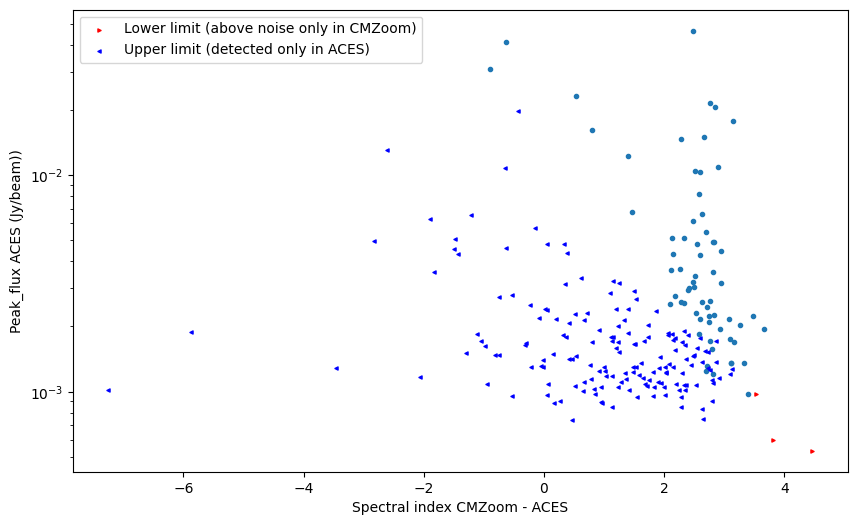

In [53]:
plt.figure(figsize=(10, 6))
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
plt.scatter(SI_above_5RMS_cmzoom, ACES_cat['peak_flux'][~both_below_5RMS_cmzoom], marker = '.')
plt.scatter(SI_lower_limits_cmzoom, ACES_cat['peak_flux'][only_ACES_below_5RMS_cmzoom], marker = '>', color = 'r', label = 'Lower limit (above noise only in CMZoom)', s = 5)
plt.scatter(SI_upper_limits_cmzoom, ACES_cat['peak_flux'][only_CMZOOM_below_5RMS], marker = '<', color = 'b', label = 'Upper limit (detected only in ACES)', s =5)
plt.yscale('log')
plt.xlabel('Spectral index CMZoom - ACES')
plt.ylabel('Peak_flux ACES (Jy/beam))')
plt.legend()
#plt.xlim(-1.5,1.5)
#plt.ylim(0.0002,0.2)

In [87]:
get_spectral_index(10, 5, aces_freq, cmzoom_freq)

<Quantity -0.85475565>

Text(0, 0.5, 'Spectral index CMZoom - ACES')

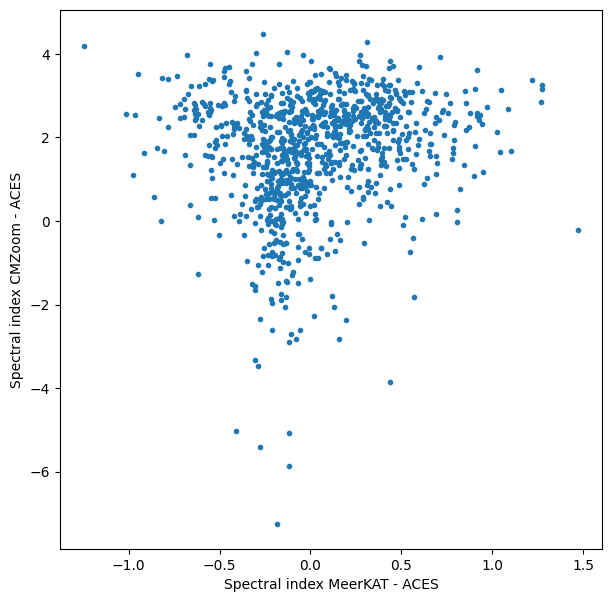

In [54]:
plt.figure(figsize=(7,7))
plt.scatter(alphas_meerkat_aces, alphas_cmzoom_aces, marker = '.')
plt.xlabel('Spectral index MeerKAT - ACES')
plt.ylabel('Spectral index CMZoom - ACES')

Text(0, 0.5, 'Spectral index CMZoom - ACES')

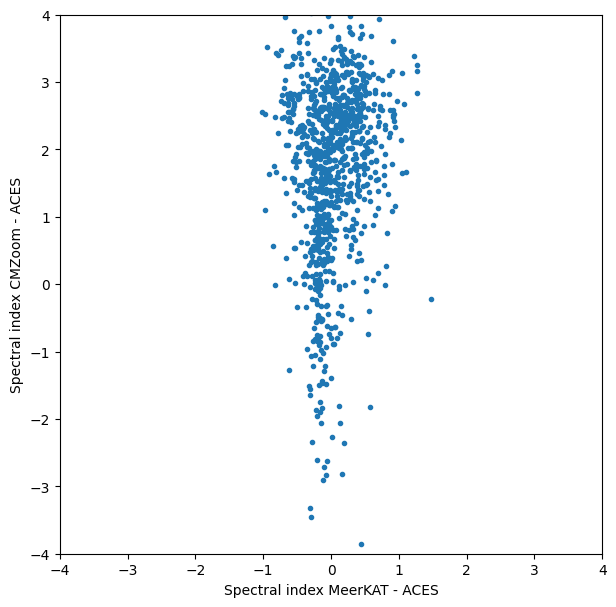

In [55]:
plt.figure(figsize=(7,7))
plt.scatter(alphas_meerkat_aces, alphas_cmzoom_aces, marker = '.')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel('Spectral index MeerKAT - ACES')
plt.ylabel('Spectral index CMZoom - ACES')

In [56]:
len(alphas_meerkat_aces)

6214

/var/folders/xx/rsxxk99x00n0v43ch_649m5c0000gn/T/ipykernel_62939/3222712367.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


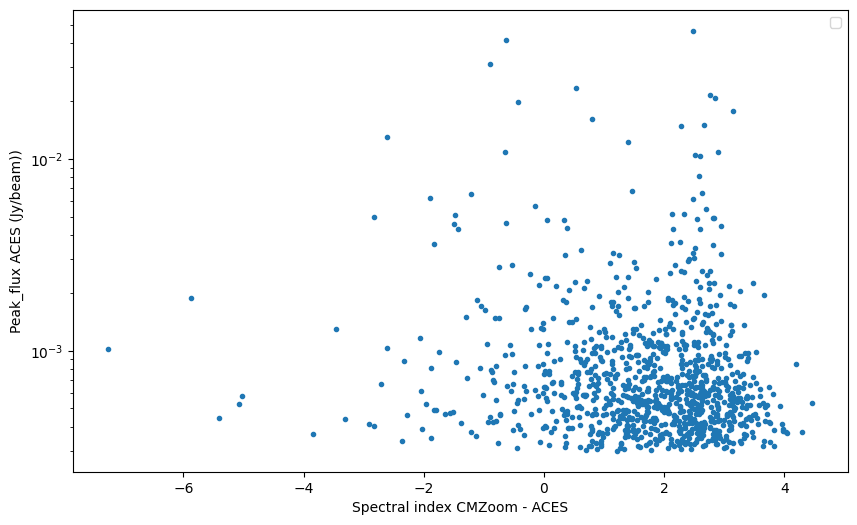

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(alphas_cmzoom_aces, ACES_cat['peak_flux'], marker = '.')
plt.yscale('log')
plt.xlabel('Spectral index CMZoom - ACES')
plt.ylabel('Peak_flux ACES (Jy/beam))')
plt.legend()

In [58]:
# SI_upper_limits_CMZOOM = alphas_meerkat_aces[only_ACES_below_5RMS]  # Only ACES < 5σ
# SI_lower_limits_CMZOOM = alphas_meerkat_aces[only_MEERKAT_below_5RMS]  # Only MEERKAT < 5σ
# SI_above_5RMS_CMZOOM = alphas_meerkat_aces[~ACES_MEERKAT_5rms_mask]  # Neither below 5σ

# SI_upper_limits = alphas_meerkat_aces[only_ACES_below_5RMS]  # Only ACES < 5σ
# SI_lower_limits = alphas_meerkat_aces[only_MEERKAT_below_5RMS]  # Only MEERKAT < 5σ
# SI_above_5RMS = alphas_meerkat_aces[~ACES_MEERKAT_5rms_mask]  # Neither below 5σ

(0.0002, 0.2)

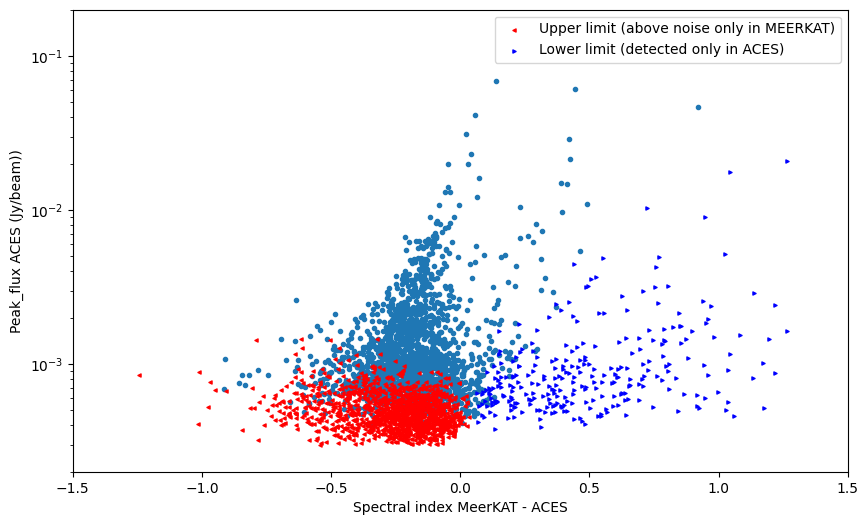

In [59]:
plt.figure(figsize=(10, 6))
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
plt.scatter(SI_above_5RMS, ACES_cat['peak_flux'][~ACES_MEERKAT_5rms_mask], marker = '.')
plt.scatter(SI_upper_limits, ACES_cat['peak_flux'][only_ACES_below_5RMS], marker = '<', color = 'r', label = 'Upper limit (above noise only in MEERKAT)', s = 5)
plt.scatter(SI_lower_limits, ACES_cat['peak_flux'][only_MEERKAT_below_5RMS], marker = '>', color = 'b', label = 'Lower limit (detected only in ACES)', s =5)
plt.yscale('log')
plt.xlabel('Spectral index MeerKAT - ACES')
plt.ylabel('Peak_flux ACES (Jy/beam))')
plt.legend()
plt.xlim(-1.5,1.5)
plt.ylim(0.0002,0.2)

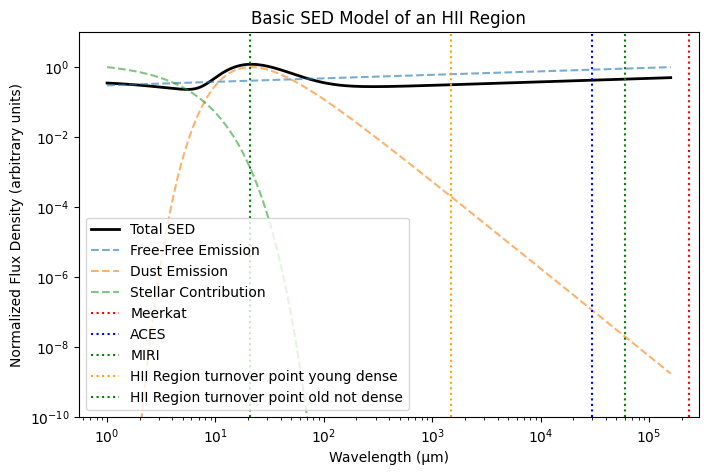

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

# Define wavelength range (in microns)
wavelength = np.logspace(0, 5.2, 200)  # 1 to 3000 microns

# Free-free emission (power law: S_nu ∝ ν^(-0.1) in optically thin regime)
nu = 3e14 / wavelength  # Frequency in Hz (approx conversion: c / lambda)
S_ff = nu**(-0.1)  

# Dust emission (Modified blackbody with T_d ~ 50 K)
h = 6.626e-34  # Planck's constant (J s)
c = 3e8        # Speed of light (m/s)
k = 1.381e-23  # Boltzmann constant (J/K)
T_d = 200       # Dust temperature in K
beta = 1.5     # Dust emissivity index

B_lambda = (2*h*c**2 / (wavelength*1e-6)**5) / (np.exp(h*c / (wavelength*1e-6 * k * T_d) ) - 1)
S_dust = B_lambda * (wavelength / 100)**beta  # Adding emissivity dependence

# Stellar component (Approximate as a power law in near-IR)
S_star = np.exp(-wavelength / 3)  # Exponential drop-off beyond a few microns

# Normalize and combine components
S_ff /= S_ff.max()
S_dust /= S_dust.max()
S_star /= S_star.max()

# Total SED (weighted sum)
SED = 0.5 * S_ff + 1.0 * S_dust + 0.2 * S_star

# Plot the SED
plt.figure(figsize=(8, 5))
plt.loglog(wavelength, SED, label="Total SED", color='k', lw=2)
plt.loglog(wavelength, S_ff, '--', label="Free-Free Emission", alpha=0.6)
plt.loglog(wavelength, S_dust, '--', label="Dust Emission", alpha=0.6)
plt.loglog(wavelength, S_star, '--', label="Stellar Contribution", alpha=0.6)

plt.ylim(1e-10, 1e1)

plt.xlabel("Wavelength (µm)")
plt.ylabel("Normalized Flux Density (arbitrary units)")
plt.title("Basic SED Model of an HII Region")
#plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.axvline((23.35*u.cm).to(u.um).value, color='r', linestyle=':', label='Meerkat')
plt.axvline((3*u.cm).to(u.um).value, color='b', linestyle=':', label='ACES')
plt.axvline(21, color='g', linestyle=':', label='MIRI')


### HII Region turover point - from 200 GHz to <10 GHz for less dense objects
plt.axvline((1.5*u.mm).to(u.um).value, color='orange', linestyle=':', label='HII Region turnover point young dense')
plt.axvline((60*u.mm).to(u.um).value, color='green', linestyle=':', label='HII Region turnover point old not dense')
plt.legend()
plt.show()

In [61]:
np.nansum(alphas_filtered)

np.float64(57.25405436197685)

In [62]:
len(alphas_err)

6214

In [63]:
ACES_cat[0]['peak_flux']

np.float64(0.0006276493852050102)

In [64]:
plot.scatter(occurances_lowres, ACES_cat[ids_ACES]['peak_flux'], marker = 'o', color = 'k', facecolors='none', edgecolors='k')

NameError: name 'plot' is not defined

In [ ]:
base = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/Protostellar_Cores_in_SgrB2/Continuum/lowres_cat.txt'
lowres = Table.read(base, format='ipac')
lowres = lowres[lowres['sum']!=0]
lowres_noHII = lowres[np.where(lowres['SIMBAD_OTYPE']!='HII')]
lowres_noHII = lowres_noHII[np.where(lowres_noHII['SIMBAD_OTYPE']!='maser')]
lowres = lowres_noHII

In [ ]:
cat_N = Table.read('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/Protostellar_Cores_in_SgrB2/Continuum/published_catalogs/catNB3_full-1.dat', format = 'mrt')
cat_M = Table.read('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/Protostellar_Cores_in_SgrB2/Continuum/published_catalogs/catMB3_full-1.dat', format = 'mrt')
catB3_m = vstack([cat_N, cat_M])

In [ ]:
catB3_m = catB3_m[catB3_m['Source'] == 'core']

In [ ]:
catB3_m

ID,"$S_{\nu,flux}$","$S_{\nu,peak}$","$S_{\nu,",FWHM$_{maj}$,FWHM$_{min}$,RA,Dec,Score,Source,G18,ID$_{Band,$T_B$,$\alpha$,$\alpha_{err}$,Mass
,mJy,mJy.beam-1,mJy.beam-1,arcsec,arcsec,,,,,,,K,,,Msun
int64,float64,float64,float64,float64,float64,str13,str13,int64,str8,str11,int64,int64,float64,float64,float64
1,0.71,0.43,0.032,0.115,0.071,17:47:19.884,-28:22:20.316,2,core,--,--,--,2.4,0.2,11.0
2,1.97,1.48,0.032,0.092,0.082,17:47:19.9464,-28:22:19.992,2,core,--,11,2,2.1,0.0,30.0
3,1.23,1.14,0.032,0.076,0.061,17:47:19.9368,-28:22:19.812,2,core,--,15,2,2.4,0.0,18.0
4,7.2,3.39,0.032,0.176,0.059,17:47:19.908,-28:22:19.452,1,core,--,31,6,2.0,0.0,108.0
6,1.2,1.11,0.032,0.098,0.054,17:47:19.9272,-28:22:19.272,2,core,--,1,2,2.4,0.1,18.0
8,0.67,0.47,0.032,0.105,0.072,17:47:19.9632,-28:22:18.84,2,core,--,--,--,2.2,0.3,11.0
9,0.97,0.71,0.032,0.093,0.064,17:47:19.9032,-28:22:18.804,1,core,--,--,1,2.2,0.2,15.0
11,2.45,1.66,0.032,0.115,0.078,17:47:19.9512,-28:22:18.624,2,core,--,4,3,1.3,0.2,37.0


In [ ]:
ra1 = catB3_m['RA']
dec1 = catB3_m['Dec']
ra2 = lowres['RA']
dec2 = lowres['Dec']
c1 = SkyCoord(ra1, dec1, frame='icrs', unit=('hourangle','deg'))
c2 = SkyCoord(ra2, dec2, frame='icrs', unit='deg')
path = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/Protostellar_Cores_in_SgrB2/Continuum/Best image low res/SgrB2_selfcal_full_TCTE7m_selfcal6_ampphase_taylorterms_multiscale_deeper_mask1.5mJy.image.tt0.pbcor.fits'
hdu = fits.open(path)[0]
my_beam = Beam.from_fits_header(hdu.header)
radius = ((my_beam.major+my_beam.minor)/2)*1.5

In [ ]:
idxc, idxcatalog, d2d, d3d = c1.search_around_sky(c2, radius)

In [ ]:
ids_lowres = np.array(Counter(idxc).most_common())[:,0]
occurances_lowres = np.array(Counter(idxc).most_common())[:,1]
occurances_lowres_over1 = occurances_lowres[occurances_lowres>1]
ids_lowres_over1 = ids_lowres[occurances_lowres>1]

occurances_lowres_1 = occurances_lowres[occurances_lowres==1]
ids_lowres_1 = ids_lowres[occurances_lowres==1]

In [ ]:

# Define the power law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power law to the data
popt, pcov = curve_fit(power_law, occurances_lowres, lowres[ids_lowres]['peak'])

# Extract the parameters
a, b = popt

# Generate the fitted line
fit_line_power_law = power_law(occurances_lowres, a, b)

In [ ]:
b

np.float64(0.5590875715181814)

In [ ]:
coefficients = np.polyfit(occurances_lowres, lowres[ids_lowres]['peak'], 1)
fit_line = np.polyval(coefficients, occurances_lowres)

In [ ]:
coefficients

array([0.00222717, 0.00456603])

Text(0.5, 1.0, 'Sgr B2, G18 - B24; 5000 - 900 AU')

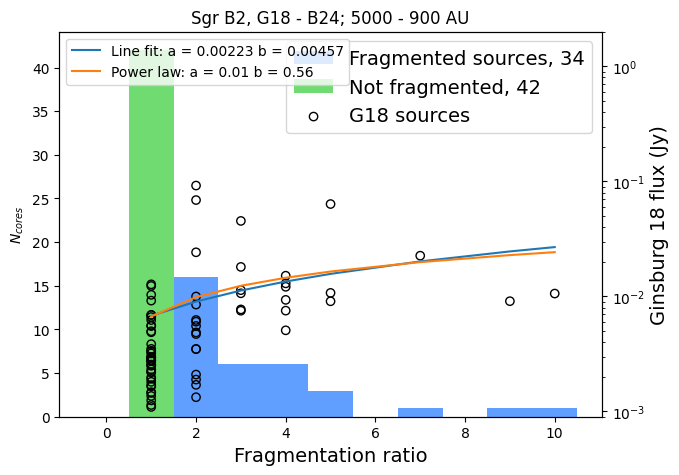

In [ ]:
fontsize = 14
fig, ax = plt.subplots(figsize=(7,5))

bins=np.linspace(-0.5,10.5, 12)
plt.hist(occurances_lowres_over1, alpha = 1, linewidth = 2, histtype = 'stepfilled', ec = 'blue', bins=bins, 
         label = 'Fragmented sources, '+str(len(occurances_lowres_over1)), color = '#609fff')
plt.hist(occurances_lowres_1, alpha = 0.7, linewidth = 2, histtype = 'stepfilled', bins=np.linspace(0.5,1.5, 2), 
         label = 'Not fragmented, '+str(len(occurances_lowres_1)), color = '#33cc33', ec = 'green')
#plt.hist([number_of_lowres_resolved_out, number_of_lowres_resolved_out_low_conf], alpha = 0.7, linewidth = 2, 
##         histtype = 'stepfilled', color = ['red', 'orange'], 
 #        ec = 'orange', bins=np.linspace(-0.5,0.5, 2), stacked = True, hatch=['/','|'],  
#         label = ['Resolved out, '+str(len(number_of_lowres_resolved_out)), 'Resolved out, low confidence, '+str(len(number_of_lowres_resolved_out_low_conf))])

plt.xlabel('Fragmentation ratio', fontsize = fontsize)
plt.ylabel(r'$N_{cores}$')

plt.scatter(np.nan,np.nan, marker = 'o', color = 'k', facecolors='none', edgecolors='k', label = 'G18 sources') 
plt.legend(fontsize = fontsize,)   

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.scatter(occurances_lowres, lowres[ids_lowres]['peak'], marker = 'o', color = 'k', facecolors='none', edgecolors='k')
#ax2.scatter(number_of_lowres_resolved_out, arr_resolved_out, marker = 'o', color = 'k', facecolors='none', edgecolors='k')
#ax2.scatter(number_of_lowres_resolved_out_low_conf, arr_resolved_out_low_conf, marker = 'o', color = 'k', facecolors='none', edgecolors='k')
plt.yscale('log')
#plt.xscale('log')
ax2.plot(occurances_lowres, fit_line, '-', label=f'Line fit: a = {round(coefficients[0],5)} b = {round(coefficients[1],5)}')
ax2.plot(occurances_lowres, fit_line_power_law, '-', label=f'Power law: a = {round(a,2)} b = {round(b,2)}')
plt.ylim(0.0009,2)
ax2.set_ylabel("Ginsburg 18 flux (Jy)",fontsize=14)
ax2.legend(loc = 'upper left')
plt.title('Sgr B2, G18 - B24; 5000 - 900 AU')
#plt.savefig('flux_fragmentation.png',dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'Sgr B2, G18 - B24; 5000 - 900 AU')

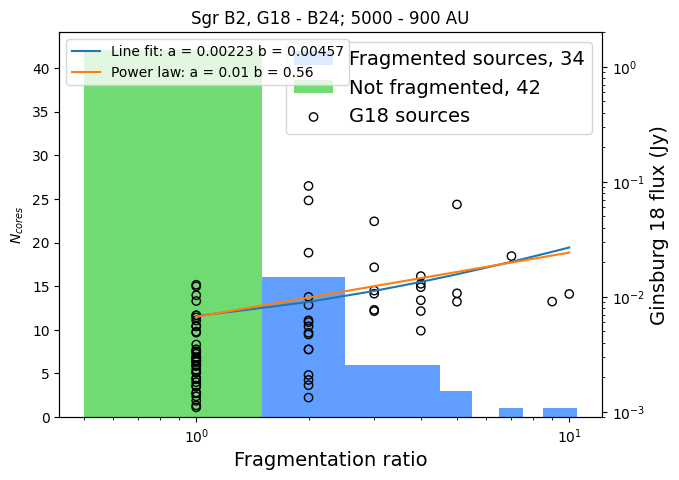

In [ ]:
fontsize = 14
fig, ax = plt.subplots(figsize=(7,5))

bins=np.linspace(-0.5,10.5, 12)
plt.hist(occurances_lowres_over1, alpha = 1, linewidth = 2, histtype = 'stepfilled', ec = 'blue', bins=bins, 
         label = 'Fragmented sources, '+str(len(occurances_lowres_over1)), color = '#609fff')
plt.hist(occurances_lowres_1, alpha = 0.7, linewidth = 2, histtype = 'stepfilled', bins=np.linspace(0.5,1.5, 2), 
         label = 'Not fragmented, '+str(len(occurances_lowres_1)), color = '#33cc33', ec = 'green')
#plt.hist([number_of_lowres_resolved_out, number_of_lowres_resolved_out_low_conf], alpha = 0.7, linewidth = 2, 
##         histtype = 'stepfilled', color = ['red', 'orange'], 
 #        ec = 'orange', bins=np.linspace(-0.5,0.5, 2), stacked = True, hatch=['/','|'],  
#         label = ['Resolved out, '+str(len(number_of_lowres_resolved_out)), 'Resolved out, low confidence, '+str(len(number_of_lowres_resolved_out_low_conf))])

plt.xlabel('Fragmentation ratio', fontsize = fontsize)
plt.ylabel(r'$N_{cores}$')

plt.scatter(np.nan,np.nan, marker = 'o', color = 'k', facecolors='none', edgecolors='k', label = 'G18 sources') 
plt.legend(fontsize = fontsize,)   

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.scatter(occurances_lowres, lowres[ids_lowres]['peak'], marker = 'o', color = 'k', facecolors='none', edgecolors='k')
#ax2.scatter(number_of_lowres_resolved_out, arr_resolved_out, marker = 'o', color = 'k', facecolors='none', edgecolors='k')
#ax2.scatter(number_of_lowres_resolved_out_low_conf, arr_resolved_out_low_conf, marker = 'o', color = 'k', facecolors='none', edgecolors='k')
plt.yscale('log')
plt.xscale('log')
ax2.plot(occurances_lowres, fit_line, '-', label=f'Line fit: a = {round(coefficients[0],5)} b = {round(coefficients[1],5)}')
ax2.plot(occurances_lowres, fit_line_power_law, '-', label=f'Power law: a = {round(a,2)} b = {round(b,2)}')
plt.ylim(0.0009,2)
ax2.set_ylabel("Ginsburg 18 flux (Jy)",fontsize=14)
ax2.legend(loc = 'upper left')
plt.title('Sgr B2, G18 - B24; 5000 - 900 AU')
#plt.savefig('flux_fragmentation.png',dpi=300,bbox_inches='tight')